### Load and analyze the dataset

In [ ]:
from PIL import ImageDraw, ImageFont, Image

img_dir = r'C:\Users\Habram\Documents\Datasets_final\real2real\testing_data\images'
dat_dir = r'C:\Users\Habram\Documents\Datasets_final\real2real\testing_data\annotations'
file = r'\Gas-Union'

invoice = Image.open(img_dir + file + '.tif')
invoice = invoice.convert('RGB')

draw = ImageDraw.Draw(invoice)
font = ImageFont.load_default()

import json

# Opening JSON file
f = open(dat_dir + file + '.json')
data = json.load(f)

for entry in data:
    for word in entry['words']:
        draw.rectangle(word['box'], outline='grey')
        
    box = entry['box']
    if entry['label'] == 'Other':
        draw.rectangle(box, outline='green')
        draw.text((box[0] + 10, box[1] - 10), text=entry['label'], fill='green', font=font)
    else:
        draw.rectangle(box, outline='red')
        draw.text((box[0] + 10, box[1] - 10), text=entry['label'], fill='red', font=font)

invoice.show()

In [1]:
from datasets import load_dataset

variant = 'hybrid'

# Load the custom dataset (or it if it does not exist)
# Param 1: location of the dataset loader script
# Param 2: location of cache folder, where the dataset will be saved
dataset = load_dataset(rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real\{variant}2real.py',
                       cache_dir=rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real')

c:\Users\Habram\Anaconda3\envs\LayoutXLM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating train split: 204 examples [00:25,  4.40 examples/s]c:\Users\Habram\Anaconda3\envs\LayoutXLM\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dataset hybrid2real downloaded and prepared to C:/Users/Habram/Documents/Datasets_final/hybrid2real/hybrid2real/default/0.0.0/3b7df60835f91aeb5dd08a3beca752e3d91a10dfbe3607a7bfee7387513c5788. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 176.61it/s]


In [ ]:
dataset

In [2]:
features = dataset["train"].features
label_column_name = "ner_tags"

# Define the dictionaries which associate the labels with integer IDs
label_list = features[label_column_name].feature.names
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}

### Load the model, tokenizer, image processor

In [3]:
from transformers import LayoutLMv2ImageProcessor, LayoutXLMTokenizer
from transformers import LayoutLMv2Model
import torch

image_processor = LayoutLMv2ImageProcessor(apply_ocr=False)
tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")

# Load the pre-trained model without classification head
model = LayoutLMv2Model.from_pretrained("microsoft/layoutxlm-base")

Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2Model: ['layoutlmv2.visual.backbone.bottom_up.res4.14.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.b

### Extract the embeddings (output of the LayoutXLM model)

In [8]:
from dataclasses import dataclass
from torch.utils.data import DataLoader

@dataclass
class DataCollatorForTokenClassification:
    feature_extractor: LayoutLMv2ImageProcessor
    tokenizer: LayoutXLMTokenizer

    def __call__(self, examples):
        tokens = []
        bboxes = []
        ner_tags = []
        images = []

        for ex in examples:
            images.append(ex['image'])

        img_features = image_processor(images, return_tensors='pt').pixel_values

        for ex in examples:
            tokens.append(ex['tokens'])
            bboxes.append(ex['bboxes'])
            ner_tags.append(ex['ner_tags'])

        encoding = tokenizer(tokens, 
                     boxes=bboxes, 
                     word_labels=ner_tags, 
                     truncation=True, 
                     padding="max_length", 
                     max_length=512,
                     return_tensors='pt'
                     )

        encoding['image'] = img_features

        return encoding
    
data_collator = DataCollatorForTokenClassification(
    image_processor,
    tokenizer,
)

# Either 'train' or 'test' set, modify if needed!
dataloader = DataLoader(dataset['test'], 
                        batch_size=1, 
                        collate_fn=data_collator)

In [5]:
import numpy as np

def group_subword_embeddings(tokens, embeddings):
    groups = []
    current_group = []
    for idx, token in enumerate(tokens):
        # !Not an underscore! _ ▁, but a special character
        if token.startswith('▁'):
            if len(current_group) > 0:
                groups.append(current_group)
            current_group = [idx]
        elif token == '<s>' or token == '</s>' or token == '<pad>':
            continue
        else:
            current_group.append(idx)
    groups.append(current_group)

    grouped_embeddings = []
    grouped_tokens = []
    for group in groups:
        grouped_tokens.append(''.join([tokens[i].lstrip('▁') for i in group]))
        grouped_embeddings.append(np.array(embeddings[group[0]: group[-1]+1].mean(axis=0)))

    return grouped_tokens, np.array(grouped_embeddings)

In [9]:
from tqdm import tqdm

size_of_dataset = dataset["test"].num_rows

iterator = iter(dataloader)

all_labels = []
all_embeddings = []
all_tokens = []

# Iterate over the dataset
for iteration in tqdm(range(size_of_dataset)):
    # Preprocess one example
    example = next(iterator)

    # Remove the labels from the example + remove the -100 elements
    labels = example.pop('labels')
    labels = np.array(labels)
    labels = np.delete(labels, np.where(labels == -100))
    labels = torch.tensor(labels)

    # Perform a forward-pass on the XLM model
    with torch.no_grad():
        output = model(**example, output_hidden_states=True)

    # Get the output embeddings of the XLM model
    xlm_embeddings = output['last_hidden_state'][0]

    # Get the input IDs
    input_ids = example["input_ids"]
    
    # Convert the input IDs to sub-words
    tokens = tokenizer.convert_ids_to_tokens(*input_ids)

    # Group the sub-words and embeddings
    joined_tokens, joined_embeddings = group_subword_embeddings(tokens, xlm_embeddings)
    all_labels.append(labels)
    all_embeddings.append(joined_embeddings)
    all_tokens.append(joined_tokens)

100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


In [10]:
# Save the embeddings, labels and tokens

train_data = {
    'embeddings': all_embeddings,
    'tokens':     all_tokens,
    'labels':     all_labels
}

np.save(f'{variant}2real_test.npy', np.array(train_data, dtype=object), allow_pickle=True)

### Train a linear classifier

In [36]:
import numpy as np

training_data = np.load(f'{variant}2real_train.npy', allow_pickle=True).item()
testing_data = np.load(f'{variant}2real_test.npy', allow_pickle=True).item()

In [37]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class IstvoicesDataset(Dataset):
    def __init__(self, data):
        self.labels = data['labels']
        self.embeddings =  data['embeddings']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        lab = self.labels[idx]

        return emb, lab
    
dataset_train_torch = IstvoicesDataset(training_data)
train_dataloader = DataLoader(dataset_train_torch, batch_size=1, shuffle=True)

dataset_test_torch = IstvoicesDataset(testing_data)
test_dataloader = DataLoader(dataset_test_torch, batch_size=1, shuffle=True)

In [38]:
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(768, 35)

    def forward(self, x):
        x = self.fc(x)
        return x

In [39]:
w = torch.FloatTensor([0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1])

criterion = nn.CrossEntropyLoss(weight=w)
softmax = nn.Softmax(dim=1)

size_of_dataset = len(training_data['embeddings'])
num_epochs = 4

In [40]:
from sklearn.metrics import precision_recall_fscore_support

performance = {
        'train_loss': [],
        'test_loss': [],     
        'precision': [],
        'recall': [],
        'f1': [0],
    }

# Run 20 trials, save the best model (with the highest F1 score)
for trial in range(30):
    performance_trial = {
        'train_loss': [],
        'test_loss': [],     
        'precision': [],
        'recall': [],
        'f1': [],
    }

    net_trial = Net()
    optimizer = optim.SGD(net_trial.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        for i in range(size_of_dataset):
            # Get the embeddings and the ground truth
            train_features, train_labels = next(iter(train_dataloader))

            # Perform a forward pass
            classifier_output = net_trial(train_features)

            # Calculate the loss
            optimizer.zero_grad()
            loss = criterion(classifier_output[0], train_labels[0])

            # Perform a backward pass
            loss.backward()

            # Tune the parameters
            optimizer.step()

            # Evaluation
            if i % 20 == 0:
                sub_f1 = []
                sub_precision = []
                sub_accuracy = []
                sub_recall = []

                for test_idx in range(len(testing_data['embeddings'])):
                    test_features, test_labels = next(iter(test_dataloader))
                    predictions = net_trial(test_features)
                    predictions = softmax(predictions[0])
                    predictions = torch.argmax(predictions, dim=1)

                    prec, rec, f1, _ = precision_recall_fscore_support(y_true=test_labels[0], y_pred=predictions, average='weighted', zero_division=0.0)
                    
                    sub_f1.append(f1)
                    sub_precision.append(prec)
                    sub_recall.append(rec)
                performance_trial['train_loss'].append(float(loss))
                performance_trial['f1'].append(sum(sub_f1)/len(sub_f1))
                performance_trial['recall'].append(sum(sub_recall)/len(sub_recall))
                performance_trial['precision'].append(sum(sub_precision)/len(sub_precision))
    if performance_trial['f1'][-1] > performance['f1'][-1]:
        net = net_trial
        performance = performance_trial

In [41]:
# Save the trained classifier
torch.save(net.state_dict(), rf'{variant}2real_classifier.pt')

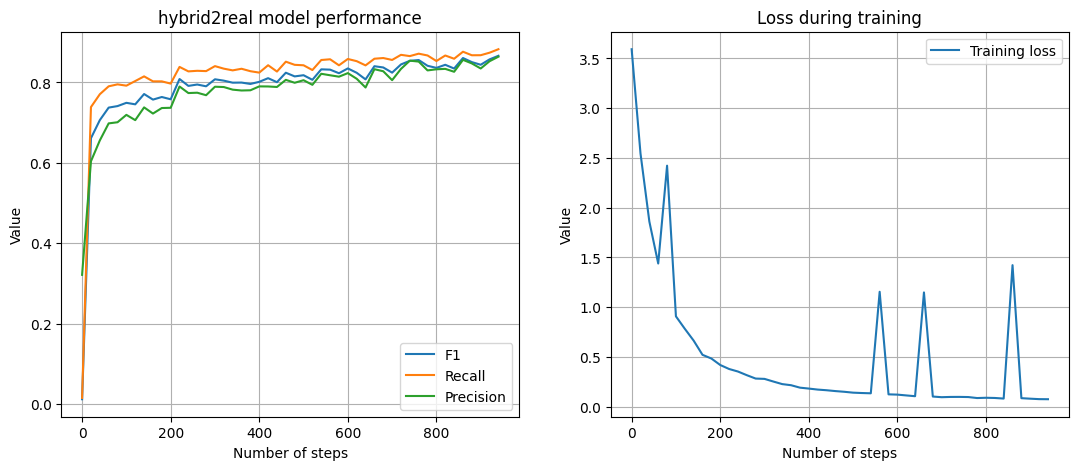

In [42]:
import matplotlib.pyplot as plt

x_axis = np.arange(len(performance['f1']))*20
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(x_axis, performance['f1'], label='F1')
ax1.plot(x_axis, performance['recall'], label='Recall')
ax1.plot(x_axis, performance['precision'], label='Precision')
ax1.set_xlabel('Number of steps')
ax1.set_ylabel('Value')
ax1.set_title('hybrid2real model performance')
ax1.grid()
ax1.legend(loc=4)

ax2.plot(x_axis, performance['train_loss'], label='Training loss')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Value')
ax2.set_title('Loss during training')
ax2.grid()
ax2.legend(loc=1)

plt.show()

In [43]:
def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label.lower()

def get_all_predictions():
    all_labels = []
    all_predictions = []
    
    # iterate over the whole test set
    for test_idx in range(len(testing_data['embeddings'])):
        test_features, test_labels = next(iter(test_dataloader))
        predictions = net(test_features)
        predictions = softmax(predictions[0])
        predictions = torch.argmax(predictions, dim=1)
        predictions = predictions.numpy()
        test_labels = test_labels[0].numpy()

        # Get the actual labels (str)
        true_predictions = [id2label[pred] for pred, label in zip(predictions, test_labels)]
        true_labels      = [id2label[label] for pred, label in zip(predictions, test_labels)]

        all_labels.append(list(map(iob_to_label, true_labels)))
        all_predictions.append(list(map(iob_to_label, true_predictions)))

    return all_labels, all_predictions

all_labels, all_predictions = get_all_predictions()

all_labels = [item.lower() for sublist in all_labels for item in sublist]
all_predictions = [item.lower() for sublist in all_predictions for item in sublist]

In [44]:
label_list = ['other',
              'r_name', 'r_street', 'r_housenumber', 'r_zip', 'r_city', 'r_country',
              's_name', 's_street', 's_housenumber', 's_zip', 's_city', 's_country',
              's_bank', 's_iban','i_number','i_date', 'i_amount',]

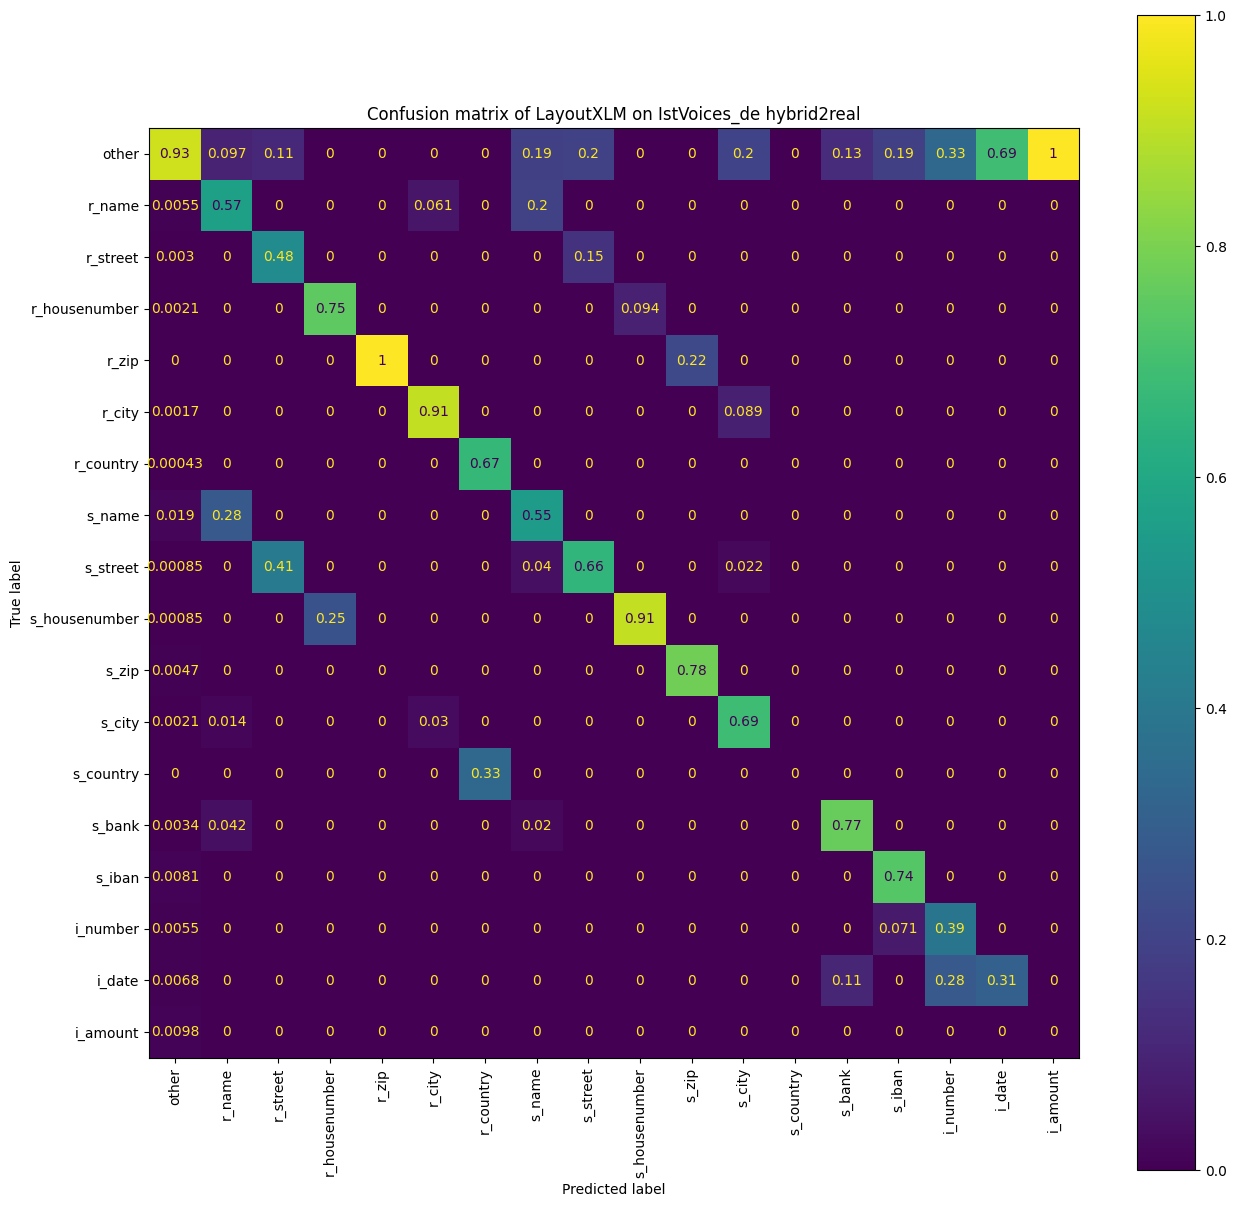

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(y_true=all_labels, y_pred=all_predictions, labels=label_list, normalize='pred')
cm_display = ConfusionMatrixDisplay(cm, display_labels=label_list)
cm_display.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion matrix of LayoutXLM on IstVoices_de hybrid2real')
plt.show()

### Visualize a prediction

In [33]:
# Get a raw example from the test set
example = dataset['test'][11]

# Prepare the example for the model
encoding = tokenizer(example['tokens'], boxes=example['bboxes'], word_labels=example['ner_tags'],
                     truncation=True, padding="max_length", max_length=512, return_tensors='pt')

img_encoding = image_processor(example['image'], return_tensors='pt').pixel_values

encoding['image'] = img_encoding

# Remove the labels from the encoding
labels = encoding.pop('labels')
labels = np.array(labels)
labels = np.delete(labels, np.where(labels == -100))
labels = torch.tensor(labels)

# Send the example through the model
with torch.no_grad():
    output = model(**encoding)

# Get the output embeddings of the XLM model
xlm_embeddings = output['last_hidden_state'][0]

# Get the input IDs
input_ids = encoding["input_ids"]

# Convert the input IDs to sub-words
tokens = tokenizer.convert_ids_to_tokens(*input_ids)

# Group the sub-words and embeddings
joined_tokens, joined_embeddings = group_subword_embeddings(tokens, xlm_embeddings)

# Send the embeddings through the classifier
predictions = net(torch.tensor(joined_embeddings))
predictions = softmax(predictions)
predictions = torch.argmax(predictions, dim=1)
predictions = predictions.numpy()
labels = labels.numpy()

# Get the actual labels (str) instead of IDs
true_predictions = [id2label[pred] for pred, label in zip(predictions, labels)]
true_labels      = [id2label[label] for pred, label in zip(predictions, labels)]

true_predictions = list(map(iob_to_label, true_predictions))
true_labels = list(map(iob_to_label, true_labels))

print(true_predictions)
print(true_labels)

['r_name', 'r_name', 'r_street', 'r_street', 's_housenumber', 's_zip', 's_city', 'other', 'r_name', 'r_city', 's_street', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 's_street', 'r_housenumber', 's_zip', 'r_city', 'r_city', 'r_city', 's_city', 'other', 'i_number', 'other', 'i_date', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'i_date', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'ot

In [35]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(example['image'])

font = ImageFont.load_default()

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

label2color = {
        'r_name':           'lightcoral',
        'r_street':         'brown',
        'r_housenumber':    'red', 
        'r_zip':            'Salmon',
        'r_city':           'chocolate',
        'r_country':        'Sandybrown',
        's_name':           'olive',      
        's_street':         'yellowgreen',
        's_housenumber':    'lawngreen',
        's_zip':            'palegreen',
        's_city':           'forestgreen',
        's_country':        'limegreen',
        's_bank':           'darkgreen',
        's_iban':           'teal',
        'i_number':         'aqua',
        'i_date':           'deepskyblue',
        'i_amount':         'blue',
        'other':            'magenta'
    }

width, height = example['image'].size

for prediction, box in zip(true_predictions, example['bboxes']):
    box_normalized = unnormalize_box(box, width, height)
    # Draw the label bounding box and name on the invoice
    draw.rectangle(box_normalized, outline=label2color[prediction])
    draw.text((box_normalized[0] + 10, box_normalized[1] - 10), text=prediction, fill=label2color[prediction], font=font)

example['image'].show()